## Astro 304 "Galaxies"

### Galaxies in the SDSS main sample

In [67]:
# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

plt.rc("savefig",dpi=175)
plt.rc('text', usetex=True)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)


The code for reading SDSS FITS files can be found in <tt>code/read_sdss_fits</tt>. Uncomment the following line if you want to see the code inlined here in the notebook. **Note that you will need to modify the directories in <tt>code/setup/setup.py</tt>  before you can read the files using the routines below.** These routines were written on Windows, which means that if you are using Linux or Mac OS you will also need to replace the forward slashes in the files paths with backslashes.

In [35]:
#%load code/read_sdss_fits.py

In [36]:
# routine data_home_dir in code/setup/setup.py should return top directory for data files

In [37]:
from code.read_sdss_fits import read_sdss_fits
from code.setup import data_home_dir

# read fits file with the SDSS DR8 main spectroscopic sample
data = read_sdss_fits(data_home_dir()+'SDSSspecgalsDR8full.fit')


Next we apply some cuts to create a well-defined magnitude-limited sample and compute some useful quantities such as Vmax of galaxies. We then select a sample of the closest and brightest galaxies for closer examination. To compute cosmological distances we will use Benedikt Diemer's <a href="https://bitbucket.org/bdiemer/colossus/overview">colossus python package</a> (we will also use other useful routines from colossus in other parts of this course).

In [38]:
import numpy as np

# lower limit on z is to avoid the nearest galaxies for which SDSS pipeline often does not perform well (splitting them into pieces, etc)
# with z_min=0.005 we are excluding galaxies closer than the Virgo cluster
# z_max=1.0 is to avoid misclassified objects that appear as very high z systems
z_min = 0.005; z_max = 1.0

# SDSS DR8 solid angle, see:
# https://www.sdss3.org/dr8/scope.php
solid_angle = 9274.*(np.pi/180)**2

# magnitude cuts appropriate for the SDSS main spectroscopic sample 
m_min = 14.0; m_max = 17.77
# correct r-band Petrosian magnitudes for Galactic extinction before applying magnitude cuts
mr = data['petroMag_r'] - data['extinction_r']
gr = data['cmodelMag_g'] - data['cmodelMag_r']
# redshift cut and magnitude cuts
data = data[(data['z'] > z_min) & (data['z'] < z_max) & (mr > m_min) & (mr < m_max) & (gr>-0.5) & (gr<2.5)]

# first let's compute some things for the entire z- and magnitude limited sample
# g-r color in model mags
gr = data['cmodelMag_g'] - data['cmodelMag_r']
mcmodel = data['cmodelMag_r']
r50 = data['petroR50_r']; z = data['z']; ext = data['extinction_r']
# extinction-corrected surface brightness using Petrosian magnitude and half-light radius
mpetro = data['petroMag_r'] - ext
sb = mpetro - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(r50)**2)

print "selected %d galaxies"%np.shape(sb)
# now compute distances and maximum comoving volume out to which galaxy would be detectable
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

# compute luminosity and angular distances
d_L = cosmo.luminosityDistance(z)/cosmo.h
d_A = d_L/(1.+z)**2

# absolute magnitude in the r-band; apply +1.3*z correction for evolution (see Bernardi et al. 2010)
# and k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
from code.calc_kcor import calc_kcor 
# this k-correction is not design for z>0.5, so limit the z for correction calculation
ihz = [z>0.6]; zk = np.copy(z); zk[ihz] = 0.6
kcorr = calc_kcor('r', zk, 'g - r', gr)

# absolute magnitude in the r-band, accounting for extinction, evolution and K-correction
Mcmodel = mcmodel - 5.0*np.log10(d_L/1e-5) - ext + 1.3*z - kcorr 
Mpetro = mpetro - 5.0*np.log10(d_L/1e-5) + 1.3*z - kcorr

# r-band luminosity in Lsun
Lcmodel =  0.4*(4.67-Mcmodel); Lpetro =  0.4*(4.67-Mpetro)

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetro))/(1.+z)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetro))/(1.+z)

# inverse Vmax comoving volume to be used as weights in distribution histograms
vmaxi = 3.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
cc = 0.93 
# final 1/Vmax
vmaxi = vmaxi / (solid_angle*cc)

# select a sample of nearby SDSS galaxies down to a given luminosity to get reasonably detailed images
Mlim = -17.0; Dmax = 100.
iloc = (Mcmodel < Mlim) & (d_A < Dmax)
locdata = data[iloc]; M_rs  = Mcmodel[iloc]
dAl = d_A[iloc]; vmaxiloc = vmaxi[iloc]
grl = locdata['modelMag_g'] - locdata['modelMag_r']

print "selected %d galaxies after magnitude and distance cuts"%np.shape(locdata)

selected 646812 galaxies
selected 10806 galaxies after magnitude and distance cuts


Now we will display a small number of these galaxies in a collage:

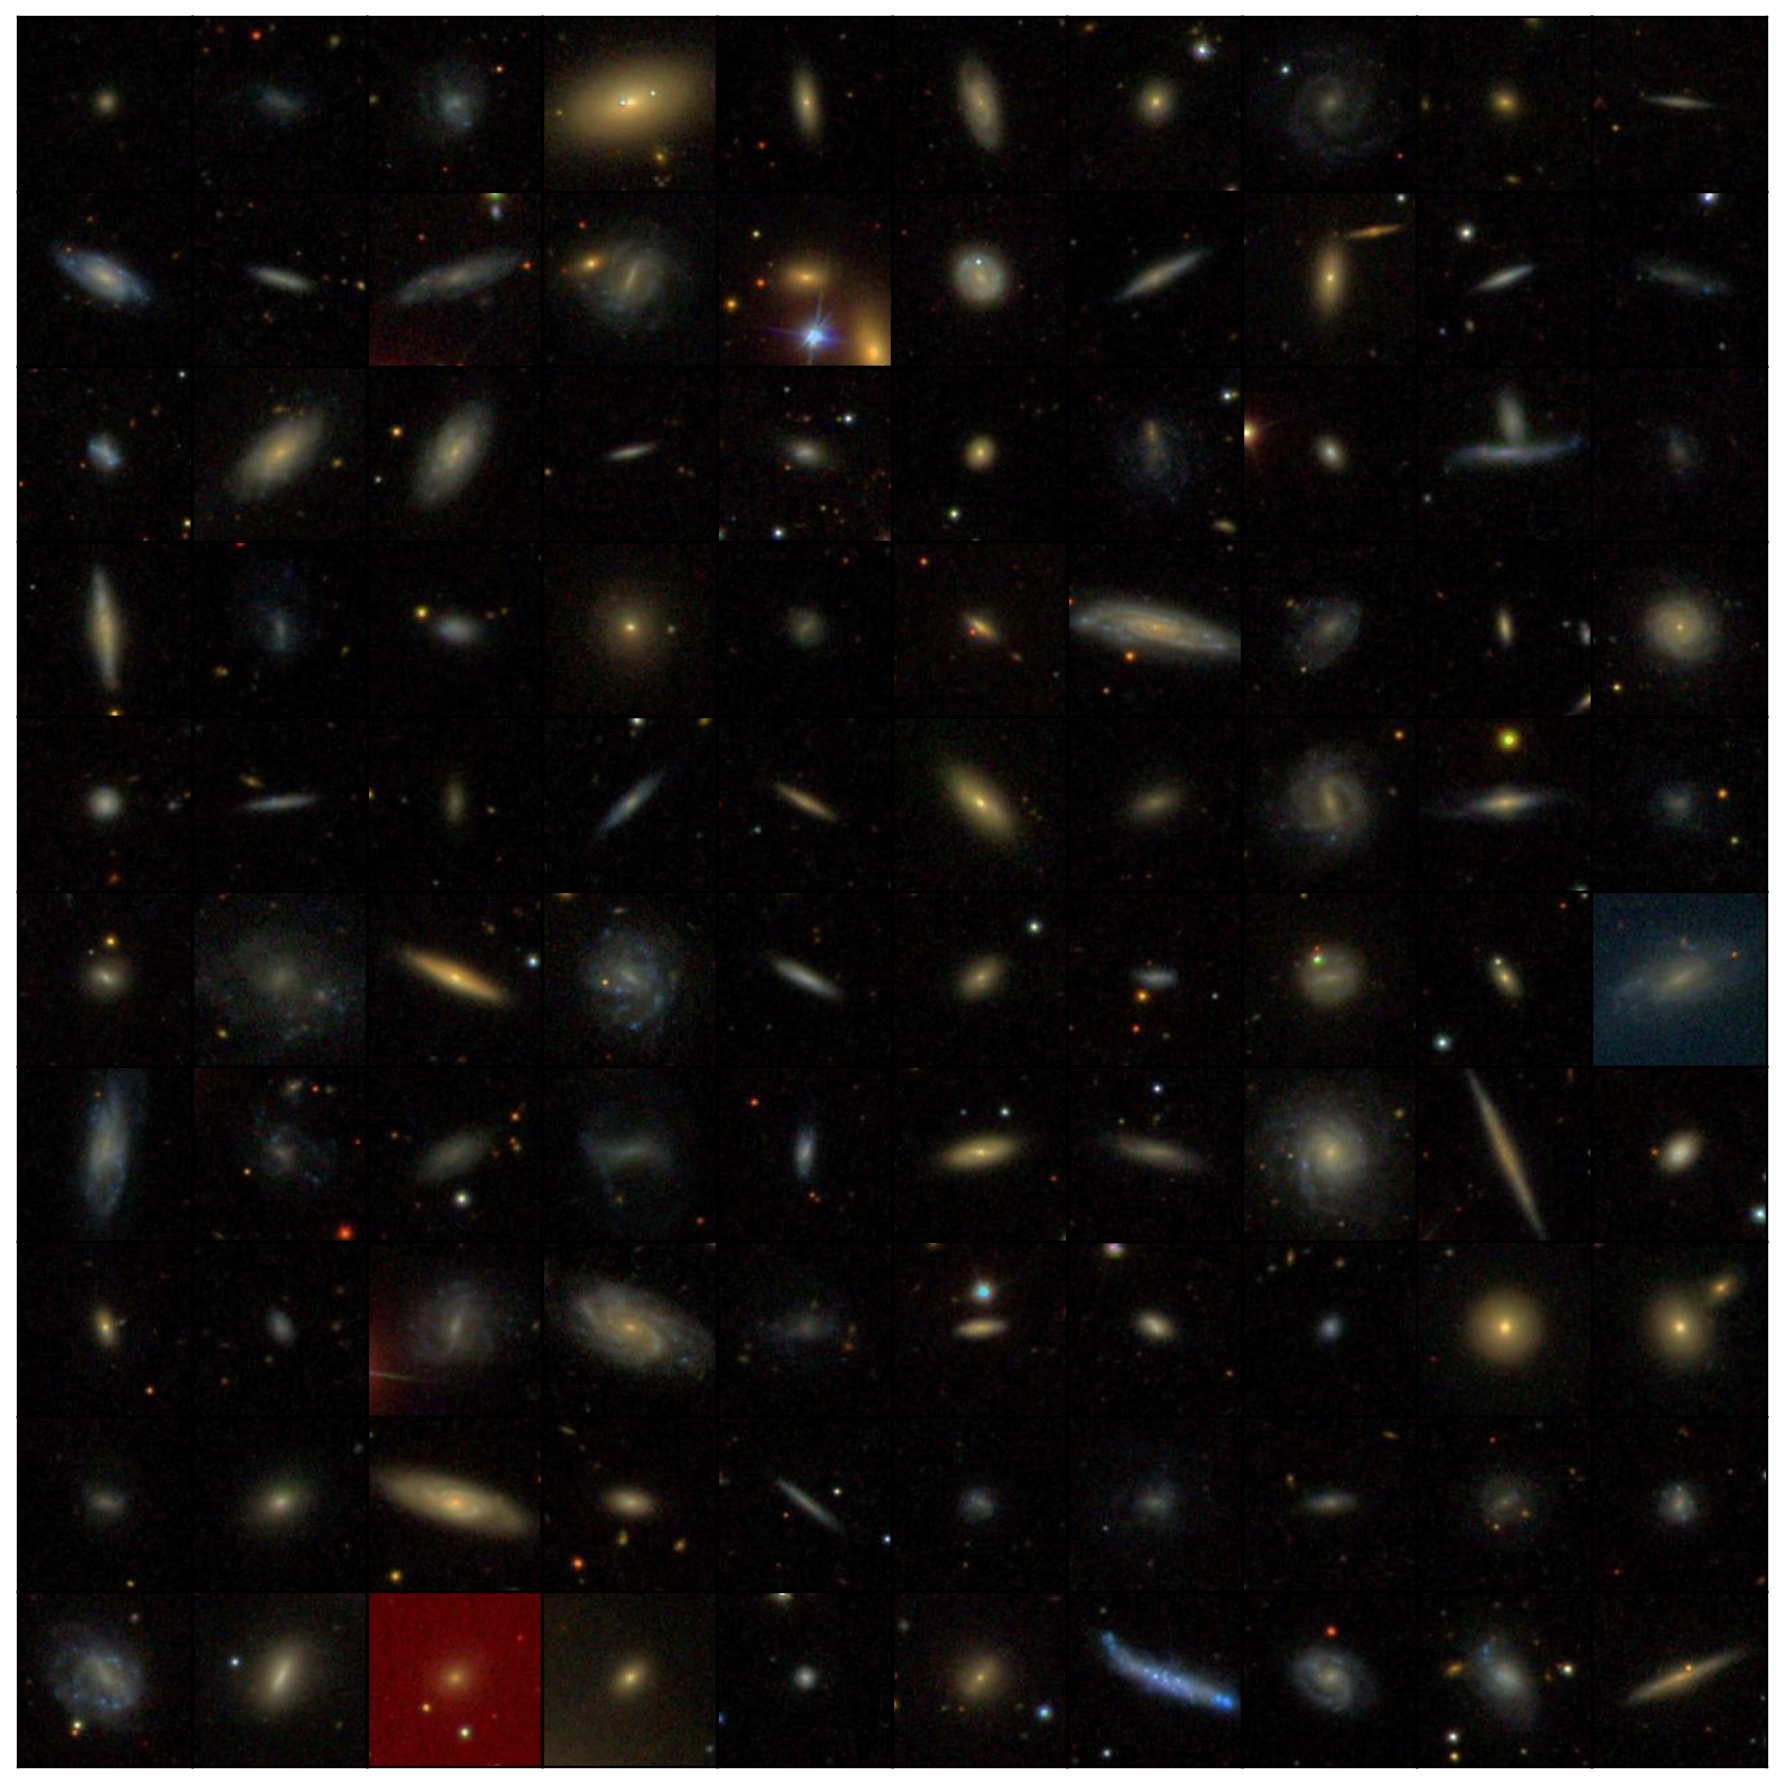

In [39]:
from code.plot_utils import sdss_img_collage

nrow = 10; ncol = 10
npix = 130

idata = locdata[(M_rs < Mlim) & (dAl>20.) & (dAl < Dmax)]
iran = np.random.randint(0.,np.size(idata)-1,nrow*ncol)
dshow = idata[iran]
objs = dshow['objID']; ras = dshow['ra']; decs = dshow['dec']

sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.5)

### Distribution of apparent magnitudes

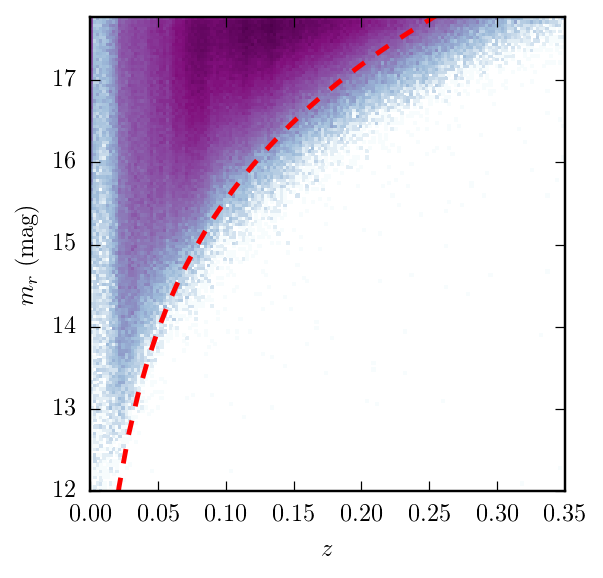

In [64]:
from colossus.cosmology import cosmology
from code.plot_utils import plot_2d_dist

def plot_mz(x,y, xlim,ylim,nxbins,nybins,xlabel,ylabel,savefig=None):
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    
    plot_2d_dist(x,y, xlim,ylim, nxbins, nybins, xlabel=xlabel, ylabel=ylabel, fig_setup=ax)
    
    # plot curve showing m-z relation for the constant luminosity ignoring K correction
    # set cosmology to the best values from 9-year WMAP data
    cosmo = cosmology.setCosmology('WMAP9')
    zd = np.linspace(x.min(), x.max(),100)
    dlum = cosmo.luminosityDistance(zd)

    mcandle = -22. + 5.*np.log10(dlum*1.e6/10.)
    plt.plot(zd, mcandle, '--', c='r', lw=2.)
    
    if savefig != None:
        plt.savefig(savefig,bbox_inches='tight')
    plt.show()
    return

from code.read_sdss_fits import read_sdss_fits
from code.setup import data_home_dir

# read fits file with the SDSS DR8 main spectroscopic sample
adata = read_sdss_fits(data_home_dir()+'SDSSspecgalsDR8full.fit')

mlim = 17.77
za = adata['z']
mra = adata['petroMag_r'] - adata['extinction_r']
adata = adata[mra<mlim]; za = za[mra<mlim]; mra = mra[mra<mlim]

#------------------------------------------------------------
# plot m-z diagram

zlim = [0.0, 0.35]; mrlim = [12.,mlim]
plot_mz(za, mra,  xlim=zlim, ylim=mrlim, nxbins=151, nybins=151, 
             xlabel=r'$z$', ylabel=r'$m_{r}\ \mathrm{(mag)}$', savefig='fig/mz_sdss.pdf')


Now the distribution of absolute magnitudes:

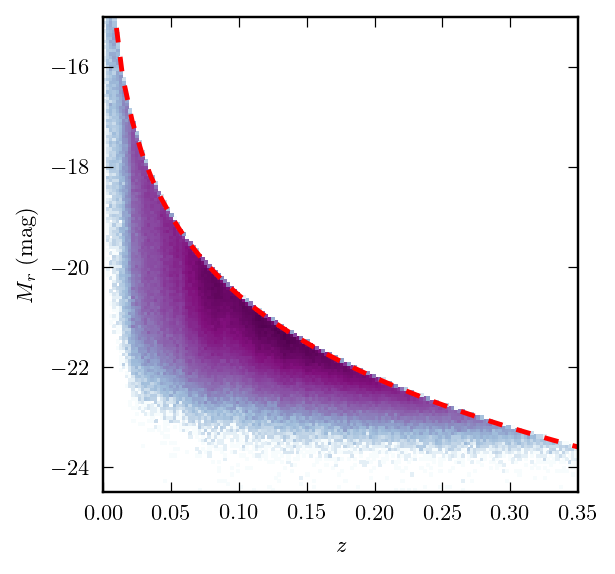

In [41]:
def plot_Mz(x,y, xlim,ylim,nxbins,nybins,xlabel,ylabel,savefig=None):
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    #
    plot_2d_dist(x,y, xlim,ylim,nxbins,nybins,xlabel=xlabel,ylabel=ylabel,fig_setup=ax)

    zd = np.linspace(x.min(), x.max(),100)
    dld = cosmo.luminosityDistance(zd)/cosmo.h
    # main galaxy magnitude limit
    Mlim = 17.77 - 5.*np.log10(dld*1.e6/10.)
    plt.plot(zd, Mlim, '--', c='r', lw=2.)

    if savefig != None:
        plt.savefig(savefig,bbox_inches='tight')
    plt.show()
    return


cosmoa = cosmology.setCosmology('WMAP9')
dluma = cosmo.luminosityDistance(za)/cosmo.h

Mra = mra - 5.0*np.log10(dluma/1e-5) 

Mrlim = [-24.5,-15.]
plot_Mz(za, Mra,  xlim=zlim, ylim=Mrlim, nxbins=151, nybins=151, 
             xlabel=r'$z$', ylabel=r'$M_{r}\ \mathrm{(mag)}$', savefig='fig/Mz_sdss.pdf')


### The Malmquist bias

Illustration of the Malmquist bias; see S 1.5, 1.51 in the notes.

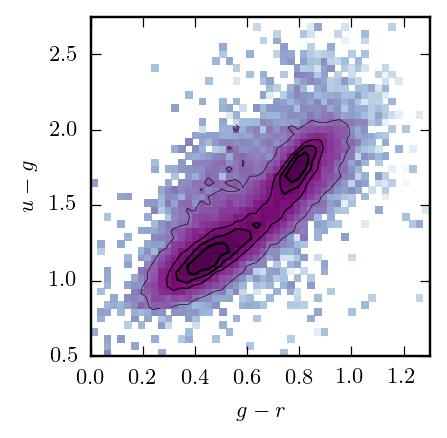

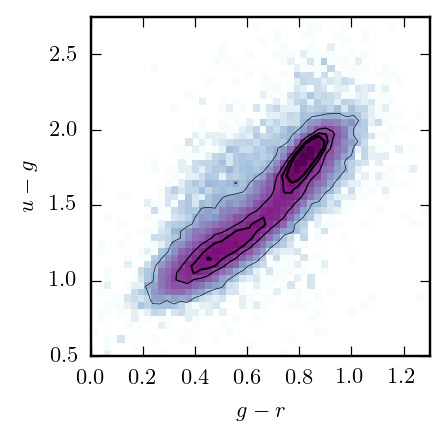

In [65]:
from code.plot_utils import plot_2d_dist

# select a sample of nearby SDSS galaxies down to a given luminosity to get reasonably detailed images
Mlim = -19.0; Dmax = 200.
iloc = (Mcmodel < Mlim) & (d_A < Dmax)
locdata = data[iloc]; M_rs  = Mcmodel[iloc]
dAl = d_A[iloc]; vmaxiloc = vmaxi[iloc]
grl = locdata['modelMag_g'] - locdata['modelMag_r']

gr = locdata['modelMag_g']-locdata['modelMag_r']
ug = locdata['modelMag_u']-locdata['modelMag_g']

grlim = [0.,1.3]; uglim = [0.5,2.75]

plt.rc('font',size=9)
clevs = np.linspace(0.2,0.95,4)

plot_2d_dist(gr, ug, grlim, uglim, weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$g-r$', ylabel=r'$u-g$', savefig='fig/colcol.pdf')
plot_2d_dist(gr, ug, grlim, uglim,  nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$g-r$', ylabel=r'$u-g$')


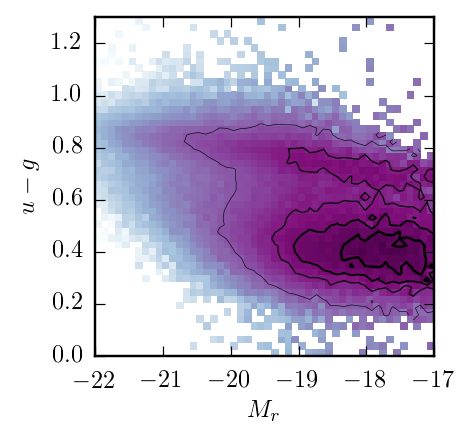

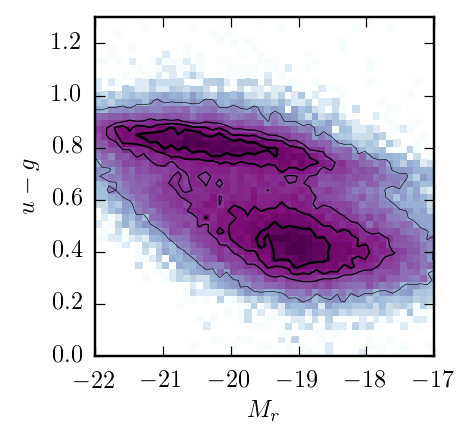

In [50]:
Mrlim = [-22.,-17.]
clevs = np.linspace(0.2,0.95,4)

plot_2d_dist(M_rs, gr, Mrlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$u-g$')

plot_2d_dist(M_rs, gr, Mrlim, grlim, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$u-g$')


### Galaxy Zoo Morphology using Meert et al. catalogs

670722 galaxies in Meert et al. sample initially
selected 240121  after all cuts...


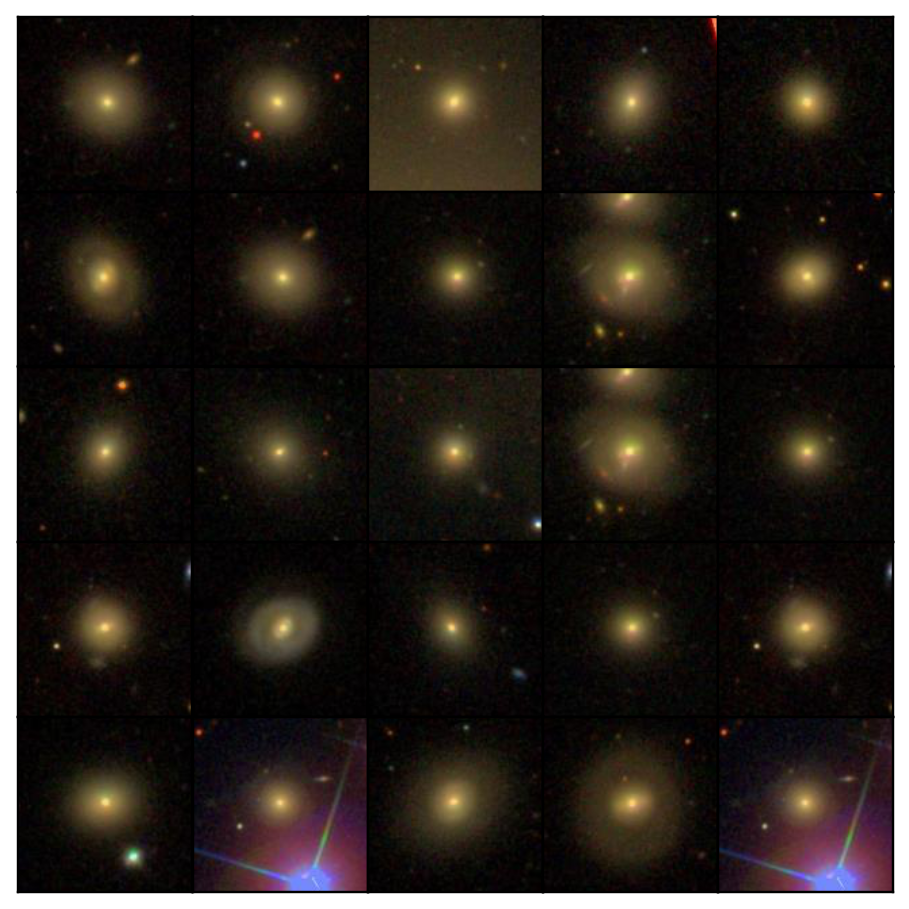

In [91]:
from code.read_data import read_meert_catalog

# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# impose sample limits
size = phot_r['petroR50']
# surface brightess = -2.5log10(f/(pi*r^2))+ const
# term - 2.5*np.log10(0.5) below is to account that we are using the *half* light radius
extm = mnpdata['extinction']
mrm = phot_r['petroMag'] - extm
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']

ilim = (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2)

sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']

print "selected", np.size(zm), " after all cuts..."

vmaxm = mnpdata['Vmax']

d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# import image collage routine
from code.plot_utils import sdss_img_collage

nrow = 5; ncol = 5
npix = 130

Dmax = 100.; Mlim = -17.0
# select Galaxy Zoo debiased probabilities for a galaxy to be classified as elliptical or spiral 
pel = sdata['p_el_debiased']; psp = sdata['p_cs_debiased']
# Bayesian machine learning probabilities of morphological classes from Huertas-Company et al. 2011, AA 525, 157
# probaE is probability to be early type (either E or S0); 1-probaE is probability to be spiral
# probaEll = probability to be elliptical; probaS0 = p(S0); probaSab = p(Sa or Sb); probaScd = p(Sc, Sd, or Irr)
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd']; 

rdata = sdata[(pEll>0.8) & (Mmeert < Mlim) & (d_Lm>20.) & (d_Lm < Dmax)]
iran = np.random.randint(0.,np.size(rdata)-1,nrow*ncol)
dshow = rdata[iran]
objs = dshow['objid']; ras = dshow['ra']; decs = dshow['dec']

sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.5)

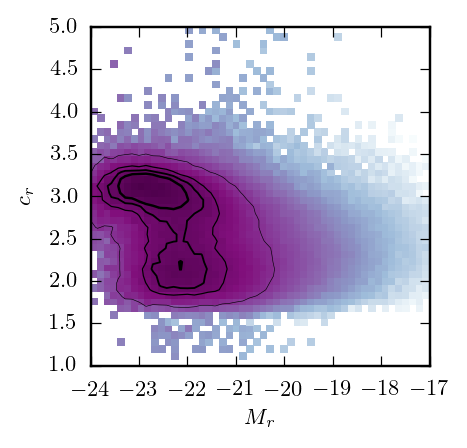

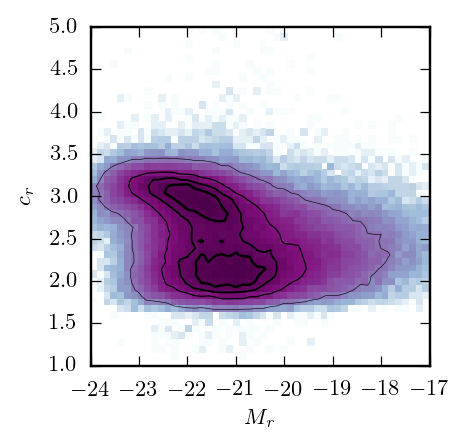

In [86]:
# concentration
cr = phot_r['petroR90']/phot_r['petroR50']
crlim = [1.,5.]; Mrlim = [-24, -17.]

plot_2d_dist(Mmeert, cr, Mrlim, crlim, weights=vmaxm, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$c_r$') #savefig='fig/colcol.pdf')

plot_2d_dist(Mmeert, cr, Mrlim, crlim, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$c_r$') #savefig='fig/colcol.pdf')
